In [14]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from deepymod.analysis import load_tensorboard
from natsort import natsorted
import os
import pandas as pd

from matplotlib.gridspec import GridSpec


In [2]:
# settings
sns.set(context='paper', style='white')
col_width = 5.5 # neurips style column width in inches



# Single run plot

In [55]:
df_pinn = load_tensorboard("runs/pinn_run_0/")
df_bayes = load_tensorboard("runs/SBL_run_0/")

In [56]:
coeff_keys_pinn = natsorted(filter(lambda key: key.find('coeff') == 0, df_pinn.keys()))
coeff_keys_bayes = natsorted(filter(lambda key: key.find('coeffs') == 0, df_bayes.keys()))
prior_keys = natsorted(filter(lambda key: key.find('alpha') == 0, df_bayes.keys()))

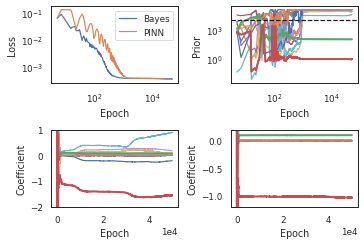

In [72]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(0.9 * col_width, 0.6 * col_width), constrained_layout=True)

ax = axes[0, 0]
ax.plot(df_bayes.index, df_bayes.mse + df_bayes.reg, label="Bayes")
ax.plot(df_pinn.index, df_pinn.mse + df_pinn.reg, label="PINN")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
#ax.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])
ax.legend()


ax = axes[0, 1]
ax.plot(df_bayes.index, df_bayes[prior_keys])
ax.plot(df_bayes.index, df_bayes[prior_keys[2]], lw=2)
ax.plot(df_bayes.index, df_bayes[prior_keys[5]], lw=2)
ax.axhline(1e4, color='k', linestyle='--')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel("Prior")
#ax.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])


ax = axes[1, 0]
ax.plot(df_pinn.index, df_pinn[coeff_keys_pinn])
ax.plot(df_pinn.index, df_pinn[coeff_keys_pinn[2]], lw=2)
ax.plot(df_pinn.index, df_pinn[coeff_keys_pinn[5]], lw=2)
#ax.set_yscale('symlog')
#ax.set_xscale('log')
ax.set_xlabel('Epoch')
ax.set_ylim([-2, 1])
ax.set_ylabel("Coefficient")
ax.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])


ax = axes[1, 1]
ax.plot(df_bayes.index, df_bayes[coeff_keys_bayes])
ax.plot(df_bayes.index, df_bayes[coeff_keys_bayes[2]], lw=2)
ax.plot(df_bayes.index, df_bayes[coeff_keys_bayes[5]], lw=2)
#ax.set_yscale('symlog')
#ax.set_xscale('log')
ax.set_xlabel('Epoch')
ax.set_ylim([-1.2, 0.2])
ax.set_ylabel("Coefficient")
ax.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])

plt.savefig('SBL.pdf', bbox_inches='tight')

# Multiple runs

In [3]:
files = natsorted([file for file in os.listdir('runs') if file.find('SBL')==0])
dfs_sbl = [load_tensorboard(f'runs/{file}') for file in files]

In [4]:
files = natsorted([file for file in os.listdir('runs') if file.find('pinn')==0])
dfs_pinn = [load_tensorboard(f'runs/{file}') for file in files]

In [5]:
def mean_std(prop, df_list, log):
    """Returns mean and std and (mean - std, mean + std) of prop for all dataframes in df_list."""
    data = np.stack([prop(df) for df in df_list], axis=-1)
    if log:
        data = np.log10(data)
    mean = np.mean(data, axis=-1)  
    std = np.std(data, axis=-1)  
    return mean, std, (mean-std, mean + std)

In [6]:
sbl_loss = mean_std(lambda df: df.mse + df.reg, dfs_sbl, log=True)
pinn_loss = mean_std(lambda df: df.mse + df.reg, dfs_pinn, log=True)
x_vals = dfs_pinn[0].index

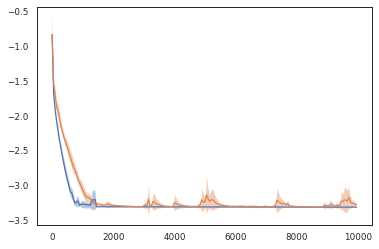

In [7]:
plt.plot(x_vals, sbl_loss[0])
plt.fill_between(x_vals, sbl_loss[2][0], sbl_loss[2][1], alpha=0.4)

plt.plot(x_vals, pinn_loss[0])
plt.fill_between(x_vals, pinn_loss[2][0], pinn_loss[2][1], alpha=0.4)

In [8]:
prior_keys = natsorted(key for key in dfs_sbl[0].keys() if key.find('alpha') == 0)
coeff_keys = natsorted(key for key in dfs_sbl[0].keys() if key.find('coeffs') == 0)
bayes_coeff_keys = natsorted(key for key in dfs_sbl[0].keys() if key.find('bayes') == 0)

In [9]:
sbl_prior = mean_std(lambda df: df[prior_keys], dfs_sbl, log=True)

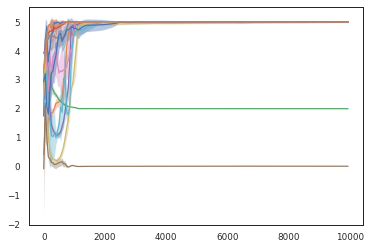

In [10]:
plt.plot(x_vals, sbl_prior[0])
for idx in np.arange(sbl_prior[0].shape[-1]):
    plt.fill_between(x_vals, sbl_prior[2][0][:, idx], sbl_prior[2][1][:, idx], alpha=0.4)

In [11]:
sbl_coeffs = mean_std(lambda df: df[coeff_keys], dfs_sbl, log=False)
pinn_coeffs = mean_std(lambda df: df[coeff_keys], dfs_pinn, log=False)

(-1.2, 1.0)

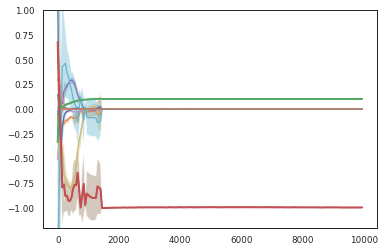

In [12]:
plt.plot(x_vals, sbl_coeffs[0])
plt.plot(x_vals, sbl_coeffs[0][:, 2], linewidth=2)
plt.plot(x_vals, sbl_coeffs[0][:, 5], linewidth=2)
for idx in np.arange(sbl_coeffs[0].shape[-1]):
    plt.fill_between(x_vals, sbl_coeffs[2][0][:, idx], sbl_coeffs[2][1][:, idx], alpha=0.4)
    
plt.ylim([-1.2, 1])

(-1.2, 1.0)

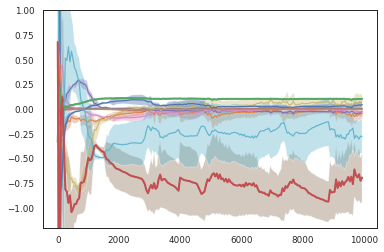

In [13]:
plt.plot(x_vals, pinn_coeffs[0])
plt.plot(x_vals, pinn_coeffs[0][:, 2], linewidth=2)
plt.plot(x_vals, pinn_coeffs[0][:, 5], linewidth=2)
for idx in np.arange(pinn_coeffs[0].shape[-1]):
    plt.fill_between(x_vals, pinn_coeffs[2][0][:, idx], pinn_coeffs[2][1][:, idx], alpha=0.4)
    
plt.ylim([-1.2, 1])

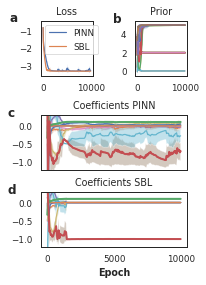

In [96]:
fig = plt.figure(constrained_layout=True, figsize=(0.5 * col_width, 0.7 * col_width))
gs = GridSpec(3, 2, figure=fig)

#Upper left
ax = fig.add_subplot(gs[0, 0])
ax.plot(x_vals, pinn_loss[0], label='PINN')
ax.fill_between(x_vals, pinn_loss[2][0], pinn_loss[2][1], alpha=0.4)

ax.plot(x_vals, sbl_loss[0], label='SBL')
ax.fill_between(x_vals, sbl_loss[2][0], sbl_loss[2][1], alpha=0.4)

#ax.set_ylim([-3.4, -2])
ax.set_title('Loss')
ax.legend()
ax.text(-7000.0, -0.5, 'a', fontdict={'weight':'bold', 'size': 12})
   
    

#Lower left
ax = fig.add_subplot(gs[0, 1])
ax.plot(x_vals, sbl_prior[0])
for idx in np.arange(sbl_prior[0].shape[-1]):
    plt.fill_between(x_vals, sbl_prior[2][0][:, idx], sbl_prior[2][1][:, idx], alpha=0.4)
ax.plot(x_vals, sbl_prior[0][:, 2], linewidth=2)
ax.plot(x_vals, sbl_prior[0][:, 2], linewidth=2)
ax.set_ylim([-0.5, 5.5])
ax.set_title("Prior")
ax.plot(x_vals, sbl_prior[0])
ax.text(-5100.0, 5.3, 'b', fontdict={'weight':'bold', 'size': 12})
   
    
# middle
ax = fig.add_subplot(gs[1, :])
ax.plot(x_vals, pinn_coeffs[0])
ax.plot(x_vals, pinn_coeffs[0][:, 2], linewidth=2)
ax.plot(x_vals, pinn_coeffs[0][:, 5], linewidth=2)
for idx in np.arange(pinn_coeffs[0].shape[-1]):
    ax.fill_between(x_vals, pinn_coeffs[2][0][:, idx], pinn_coeffs[2][1][:, idx], alpha=0.4)
ax.set_xticks([])
ax.set_ylim([-1.2, 0.3])
ax.set_title("Coefficients PINN")
ax.text(-3000.0, 0.25, 'c', fontdict={'weight':'bold', 'size': 12})
    
# right
ax = fig.add_subplot(gs[2, :])
ax.plot(x_vals, sbl_coeffs[0])
ax.plot(x_vals, sbl_coeffs[0][:, 2], linewidth=2)
ax.plot(x_vals, sbl_coeffs[0][:, 5], linewidth=2)
for idx in np.arange(sbl_coeffs[0].shape[-1]):
    ax.fill_between(x_vals, sbl_coeffs[2][0][:, idx], sbl_coeffs[2][1][:, idx], alpha=0.4)
ax.set_xlabel('Epoch', fontdict={'weight':'bold'})
ax.set_ylim([-1.2, 0.3])
ax.set_xticks([0, 5000, 10000])
ax.set_title("Coefficients SBL")
ax.text(-3000.0, 0.25, 'd', fontdict={'weight':'bold', 'size': 12})
plt.savefig('SBL.pdf', bbox_inches='tight')

In [ ]:
ax.text(-500.0, 11, 'B', fontdict={'weight':'bold', 'size': 12})
ax.legend(loc='upper right')
ax.set_xlabel('Epoch', fontdict={'weight':'bold'})
ax.set_ylabel('log prec.',  fontdict={'weight':'bold'})

ax.set_xlim([0, 2000])

In [101]:
df = dfs_sbl[0]
masked_coeff_keys = natsorted(key for key in df.keys() if key.find('masked_coeffs') == 0)

Text(0, 0.5, '$\\Delta$ BIC')

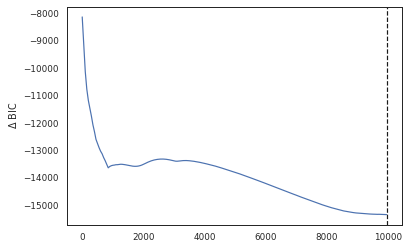

In [104]:
plt.axvline(df.BIC.idxmin(), linestyle='--', color='k')
plt.plot(df.index, df.BIC.ewm(alpha=0.1).mean())
#plt.ylim([0, 1000])
plt.ylabel(r"$\Delta$ BIC")
#plt.xlim([0, 50000])

In [105]:
true_coeffs = np.zeros((1, 12))
true_coeffs[0, 2] = 0.1
true_coeffs[0, 5] = -1

In [106]:
coeff_error = np.mean(np.abs(df[coeff_keys] - true_coeffs), axis=1)
masked_coeff_error = np.mean(np.abs(df[masked_coeff_keys] - true_coeffs), axis=1)

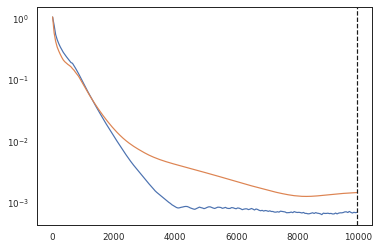

In [107]:
plt.semilogy(df.index, coeff_error.ewm(alpha=0.1).mean())
plt.semilogy(df.index, masked_coeff_error.ewm(alpha=0.1).mean())
plt.axvline(df.BIC.idxmin(), linestyle='--', color='k')

In [111]:
df[masked_coeff_keys].tail(1)

,masked_coeffs_0,masked_coeffs_1,masked_coeffs_2,masked_coeffs_3,masked_coeffs_4,masked_coeffs_5,masked_coeffs_6,masked_coeffs_7,masked_coeffs_8,masked_coeffs_9,masked_coeffs_10,masked_coeffs_11
9950,0.0,0.0,0.095757,0.0,0.0,-1.014009,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df[coeff_keys].